# Overview
### Data augmentation + EarlyStopping to avoid overfitting
- FER2013 dataset (face images + facial expression)
  + Goal: classifying facial exprression
  + Input: a 48x48 image
  + Output: facial expression (angry, disgust, fear, happy, neutral, sad, and surprise)
- Defining an CNN+MLP
- Training and evaluating an CNN+MLP

# Import libraries

In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 7   # angry, disgust, fear, happy, neutral, sad, and surprise

# (1) Data

### Download data at https://drive.google.com/drive/folders/15EozdYlGeO3d-ny8nbqFM3ojTGsj2hdE?usp=sharing
This source code and npy files MUST be in the same location

In [3]:
trainingset = np.loadtxt('/kaggle/input/fer2013/fer2013_training_onehot.csv', delimiter=',')
testingset = np.loadtxt('/kaggle/input/fer2013/fer2013_publictest_onehot.csv', delimiter=',')

trainingset

array([[ 70.,  80.,  82., ...,   0.,   0.,   0.],
       [151., 150., 147., ...,   0.,   0.,   0.],
       [231., 212., 156., ...,   0.,   0.,   0.],
       ...,
       [ 74.,  81.,  87., ...,   1.,   0.,   0.],
       [222., 227., 203., ...,   0.,   0.,   0.],
       [195., 199., 205., ...,   1.,   0.,   0.]])

In [4]:
n_inputs = 2304
n_classes = 7
img_dim = 48

x_training = trainingset[:, 0:n_inputs]
y_training = trainingset[:, n_inputs:n_inputs + n_classes]

x_testing = testingset[:, 0:n_inputs]
y_testing = testingset[:, n_inputs:n_inputs + n_classes]

x_training = x_training.reshape(x_training.shape[0], 48, 48)
x_training = np.expand_dims(x_training, axis=-1)  # shape: (batch_size, 48, 48, 1)

x_testing = x_testing.reshape(x_testing.shape[0], 48, 48)
x_testing = np.expand_dims(x_testing, axis=-1)  # shape: (batch_size, 48, 48, 1)


# (2) Declare model

In [5]:
# 64x64 portray image
input_image = Input(shape=(48, 48, 1), name='Input')

# conv, pooling layers + dropout
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_1')(input_image)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu', name='conv1_2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
x = Dropout(rate=0.25, name='conv_dropout1')(x)

x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_1')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='valid', activation='relu', name='conv2_2')(x)
x = Conv2D(filters=218, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_3')(x)
x = Conv2D(filters=218, kernel_size=(3, 3), padding='valid', activation='relu', name='conv2_4')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
x = Dropout(rate=0.25, name='conv_dropout2')(x)

# similar to the MLP example!
# matrix ---> vector
x = Flatten(name='flatten')(x)

# FC layers + dropout
x = Dense(units=1024, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5, name='fc_dropout1')(x)

output_label = Dense(units=num_classes, activation='softmax', name='fc3_7ways_softmax')(x)

# define model
model = Model(inputs=input_image, outputs=output_label, name='emo_cnn')

# print model summary
model.summary()

Model: "emo_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_1 (Conv2D)                     │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_2 (Conv2D)                     │ (None, 46, 46, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dropout1 (Dropout)              │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ (None, 23, 23, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_2 (Conv2D)                     │ (None, 21, 21, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_3 (Conv2D)                     │ (None, 21, 21, 218)         │         251,354 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_4 (Conv2D)                     │ (None, 19, 19, 218)         │         427,934 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 9, 9, 218)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dropout2 (Dropout)              │ (None, 9, 9, 218)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 17658)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 1024)                │      18,082,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_dropout1 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc3_7ways_softmax (Dense)            │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,028,287 (72.59 MB)

 Trainable params: 19,028,287 (72.59 MB)

 Non-trainable params: 0 (0.00 B)

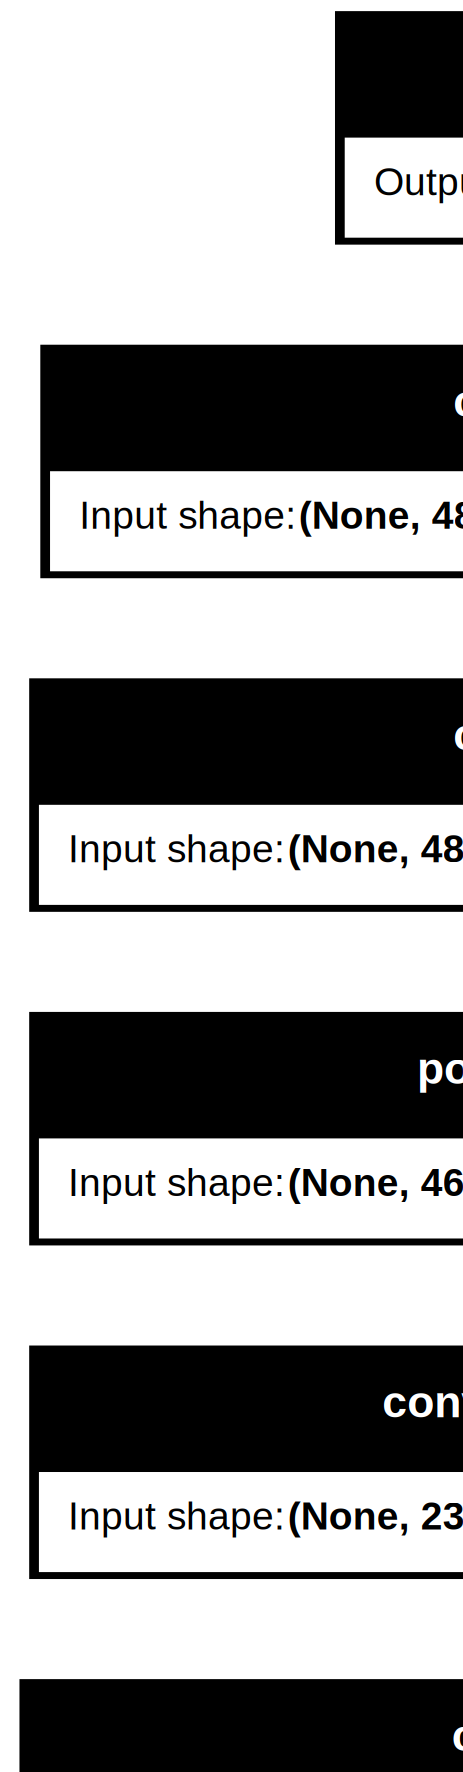

In [6]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# (3) Train defined model
- Note that the training history including loss and accuracy will be save in 'history' variable
- In case your system runs out of memory (OOM), try to decrease batch size

In [7]:
# Data augmentation
# based on https://keras.io/preprocessing/image/
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [8]:
# Khai báo loss function và optimizer
loss = 'categorical_crossentropy'
learning_rate = 0.0001
model.compile(loss=loss, optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# EarlyStopping để tránh overfitting
early_stopping_after_epochs = 5
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_after_epochs)

# Thông số huấn luyện
batch_size = 128
epochs = 100

# Bắt đầu huấn luyện
starting_time = time.time()
history = model.fit(datagen.flow(x_training, y_training, batch_size=batch_size),
                    steps_per_epoch=int(len(x_training) / batch_size),  # Ép kiểu về int
                    validation_data=(x_testing, y_testing),
                    epochs=epochs,
                    callbacks=[early_stopping])
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


224/224 ━━━━━━━━━━━━━━━━━━━━ 39s 118ms/step - accuracy: 0.2151 - loss: 3.9398 - val_accuracy: 0.2474 - val_loss: 1.8564
Epoch 2/100
  1/224 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.1953 - loss: 1.8561

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1953 - loss: 1.8561 - val_accuracy: 0.2458 - val_loss: 1.8599
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.2375 - loss: 1.8259 - val_accuracy: 0.2549 - val_loss: 1.8163
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2422 - loss: 1.8448 - val_accuracy: 0.2530 - val_loss: 1.8177
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.2564 - loss: 1.8101 - val_accuracy: 0.2608 - val_loss: 1.8007
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2109 - loss: 1.8167 - val_accuracy: 0.2605 - val_loss: 1.7998
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.2522 - loss: 1.8060 - val_accuracy: 0.2778 - val_loss: 1.7895
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1953 - loss: 1.7914 - val_accuracy: 0.2756 - val_loss: 1.7866
Epoch 9/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.2580 - loss: 1.7969 - val_accuracy

### Training time
- Training time with GTX 1080 is about 22.7489 minutes for 57 epochs. The accuracy +2% without overfitting!
- Training time with Core i7 is around ??? minutes for ??? epochs

# (4) Evaluate trained model

In [9]:
score = model.evaluate(x_testing, y_testing)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5587 - loss: 1.1935
Test loss: 1.1859394311904907
Test accuracy: 0.5564224123954773


In [10]:
def get_emotion(ohv):
    indx = np.argmax(ohv)
        
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


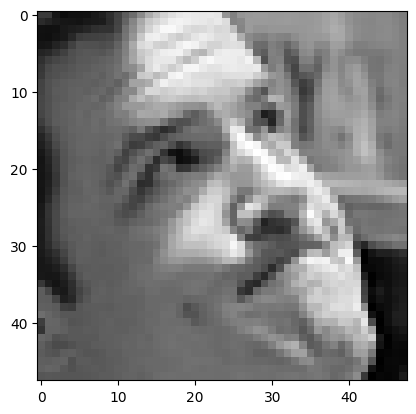

> testing image index: 1947
> true emotion: sad
> predicted emotion: sad


In [11]:
# 2163
img_indx = np.uint32(np.random.rand()*(testingset.shape[0] - 1))
sample = x_testing[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_testing[img_indx, :]), get_emotion(pred_cls)))